In [1]:
import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.shared_randomstreams import RandomStreams
from theano.tensor.nnet import conv
import sys
sys.path.append("../lib")
from logistic_sgd import LogisticRegression, load_data
from mlp import HiddenLayer
from mlp import MLP
from load import mnist
from load import faces

%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.cm as cm


Using gpu device 0: GeForce GTX 980


In [2]:
trX, teX, trY, teY  = faces(onehot = False)
#trX, teX, trY, teY  = mnist(onehot=False)

In [3]:
print trX.shape

(28709, 2304)


In [4]:
TrainX = trX[:25000]
ValX = trX[25000:]
TrainY = trY[:25000]
ValY = trY[25000:]

(3709, 2304)
(25000, 2304)
(3589, 2304)


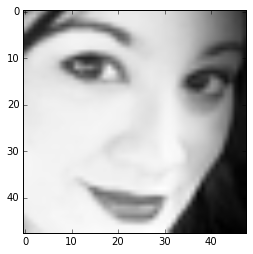

In [5]:
meanValidate = numpy.mean(TrainX , axis = 0);
meanValidate = meanValidate.reshape(48, 48)
#imshow(meanValidate,cmap = cm.Greys_r)
imshow(ValX[100].reshape(48,48),cmap = cm.Greys_r)

print ValX.shape
print TrainX.shape
print teX.shape


In [6]:
train_set_x = theano.shared(numpy.asarray(TrainX, dtype=theano.config.floatX),borrow=True)
test_set_x = theano.shared(numpy.asarray(teX, dtype=theano.config.floatX),borrow=True)
train_set_y = theano.shared(numpy.asarray(TrainY, dtype="int32"),borrow=True)
test_set_y = theano.shared(numpy.asarray(teY, dtype="int32"),borrow=True)

val_set_x = theano.shared(numpy.asarray(ValX, dtype=theano.config.floatX),borrow=True)
val_set_y = theano.shared(numpy.asarray(ValY, dtype="int32"),borrow=True)

datasets = [(train_set_x, train_set_y), (val_set_x, val_set_y),(test_set_x, test_set_y)]

In [7]:
srng = RandomStreams()

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    return updates

def dropout(X, p=0.):
    if p > 0:
        retain_prob = 1 - p
        X = X *  srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X = (X/retain_prob)
    return X

def rectify(X):
    return T.maximum(X, 0.)


In [8]:
class LeNetConvPoolLayer(object):
    """Pool Layer of a convolutional network """
    def __init__(self, rng, input, filter_shape, image_shape, poolsize=(2, 2)):
    
        assert image_shape[1] == filter_shape[1]
        self.input = input

        print "image Shape: " + str(image_shape)
        print "filter Shape" + str(filter_shape)

        # there are "num input feature maps * filter height * filter width"
        # inputs to each hidden unit
        fan_in = numpy.prod(filter_shape[1:])
        # each unit in the lower layer receives a gradient from:
        # "num output feature maps * filter height * filter width" /
        #   pooling size
        fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]) /
                   numpy.prod(poolsize))
        # initialize weights with random weights
        W_bound = numpy.sqrt(6. / (fan_in + fan_out))
        self.W = theano.shared(
            numpy.asarray(
                rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
                dtype=theano.config.floatX
            ),
            borrow=True
        )

        # the bias is a 1D tensor -- one bias per output feature map
        b_values = numpy.zeros((filter_shape[0],), dtype=theano.config.floatX)
        self.b = theano.shared(value=b_values, borrow=True)

        # convolve input feature maps with filters
        conv_out = conv.conv2d(
            input=input,
            filters=self.W,
            filter_shape=filter_shape,
            image_shape=image_shape
        )

        # downsample each feature map individually, using maxpooling
        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=False
        )

        # add the bias term. Since the bias is a vector (1D array), we first
        # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
        # thus be broadcasted across mini-batches and feature map
        # width & height
        
        #self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))
        self.output = rectify(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))

        # store parameters of this layer
        self.params = [self.W, self.b]

        # keep track of model input
        self.input = input

In [9]:
def evaluate_lenet5(learning_rate=0.1, n_epochs=200,
                    dataset='mnist.pkl.gz',
                    nkerns=[64, 128 , 256 , 512], batch_size=128):
    """ Demonstrates lenet on MNIST dataset

    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
                          gradient)

    :type n_epochs: int
    :param n_epochs: maximal number of epochs to run the optimizer

    :type dataset: string
    :param dataset: path to the dataset used for training /testing (MNIST here)

    :type nkerns: list of ints
    :param nkerns: number of kernels on each layer
    """

    rng = numpy.random.RandomState(23455)

    datasets = dataset

    train_set_x, train_set_y = datasets[0]
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]
    
    print train_set_x.get_value().shape
    print train_set_y.get_value().shape
    print valid_set_x.get_value().shape
    print valid_set_y.get_value().shape
    print test_set_x.get_value().shape
    print test_set_y.get_value().shape
    

    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0]
    n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
    n_test_batches = test_set_x.get_value(borrow=True).shape[0]
    n_train_batches /= batch_size
    n_valid_batches /= batch_size
    n_test_batches /= batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()  # index to a [mini]batch

    # start-snippet-1
    x = T.matrix('x')   # the data is presented as rasterized images
    y = T.ivector('y')  # the labels are presented as 1D vector of
                        # [int] labels

    ######################
    # BUILD ACTUAL MODEL #
    ######################
    print '... building the model'

    # Reshape matrix of rasterized images of shape (batch_size, 28 * 28)
    # to a 4D tensor, compatible with our LeNetConvPoolLayer
    # (28, 28) is the size of MNIST images.
    layer0_input = x.reshape((batch_size, 1, 48, 48))

    # Construct the first convolutional pooling layer:
    # filtering reduces the image size to (28-5+1 , 28-5+1) = (24, 24)
    # maxpooling reduces this further to (24/2, 24/2) = (12, 12)
    # 4D output tensor is thus of shape (batch_size, nkerns[0], 12, 12)
    layer0 = LeNetConvPoolLayer(
        rng,
        input=layer0_input,
        image_shape=(batch_size, 1, 48, 48),
        filter_shape=(nkerns[0], 1, 7, 7),
        poolsize=(2, 2)
    )

    layer1_input = dropout(layer0.output, 0.5)
    # Construct the second convolutional pooling layer
    # filtering reduces the image size to (12-5+1, 12-5+1) = (8, 8)
    # maxpooling reduces this further to (8/2, 8/2) = (4, 4)
    # 4D output tensor is thus of shape (batch_size, nkerns[1], 4, 4)
    layer1 = LeNetConvPoolLayer(
        rng,
        input=layer1_input,
        image_shape=(batch_size, nkerns[0], 21, 21),
        filter_shape=(nkerns[1], nkerns[0], 5, 5),
        poolsize=(2, 2)
    )
    
    layer2_input = dropout(layer1.output, 0.4)
    layer2 = LeNetConvPoolLayer(
        rng,
        input=layer2_input,
        image_shape=(batch_size, nkerns[1], 9 , 9),
        filter_shape=(nkerns[2], nkerns[1], 3, 3),
        poolsize=(1, 1)
    )
    
    layer3_input = dropout(layer2.output, 0.5)
    layer3 = LeNetConvPoolLayer(
        rng,
        input=layer3_input,
        image_shape=(batch_size, nkerns[2], 7, 7),
        filter_shape=(nkerns[3], nkerns[2], 3, 3),
        poolsize=(2, 2)
    )


    # the HiddenLayer being fully-connected, it operates on 2D matrices of
    # shape (batch_size, num_pixels) (i.e matrix of rasterized images).
    # This will generate a matrix of shape (batch_size, nkerns[1] * 4 * 4),
    # or (500, 50 * 4 * 4) = (500, 800) with the default values.
    layer4_input = layer3.output.flatten(2)
    layer4_input = dropout(layer4_input, 0.5)

    # construct a fully-connected sigmoidal layer
    layer4 = HiddenLayer(
        rng,
        input=layer4_input,
        n_in=nkerns[3] * 3 * 3,
        n_out=1000,
        activation=T.tanh
    )
    
    layer5 = MLP(
        rng,
        input = layer4.output,
        n_in = 1000,
        n_hidden=1000,
        n_out=7
    )
    

    # classify the values of the fully-connected sigmoidal layer
    #layer4 = LogisticRegression(input=layer3.output, n_in=1000, n_out=10)

    # the cost we minimize during training is the NLL of the model
    cost = layer5.negative_log_likelihood(y)

    # create a function to compute the mistakes that are made by the model
    test_model = theano.function(
        [index],
        layer5.errors(y),
        givens={
            x: test_set_x[index * batch_size: (index + 1) * batch_size],
            y: test_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    validate_model = theano.function(
        [index],
        layer5.errors(y),
        givens={
            x: valid_set_x[index * batch_size: (index + 1) * batch_size],
            y: valid_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

    # create a list of all model parameters to be fit by gradient descent
    params = layer5.params + layer4.params + layer3.params + layer2.params + layer1.params + layer0.params

    # create a list of gradients for all model parameters
    # grads = T.grad(cost, params)

    # train_model is a function that updates the model parameters by
    # SGD Since this model has many parameters, it would be tedious to
    # manually create an update rule for each model parameter. We thus
    # create the updates list by automatically looping over all
    # (params[i], grads[i]) pairs.
#     updates = [
#         (param_i, param_i - learning_rate * grad_i)
#         for param_i, grad_i in zip(params, grads)
#     ]
    
    updates = RMSprop(cost , params, lr=0.0009)
    
    train_model = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    # end-snippet-1

    ###############
    # TRAIN MODEL #
    ###############
    print '... training'
    # early-stopping parameters
    patience = 10000  # look as this many examples regardless
    patience_increase = 2  # wait this much longer when a new best is
                           # found
    improvement_threshold = 0.995  # a relative improvement of this much is
                                   # considered significant
    validation_frequency = min(n_train_batches, patience / 2)
                                  # go through this many
                                  # minibatche before checking the network
                                  # on the validation set; in this case we
                                  # check every epoch

    best_validation_loss = numpy.inf
    best_iter = 0
    test_score = 0.
    start_time = timeit.default_timer()

    epoch = 0
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in xrange(n_train_batches):

            iter = (epoch - 1) * n_train_batches + minibatch_index

            if iter % 100 == 0:
                print 'training @ iter = ', iter
            cost_ij = train_model(minibatch_index)

            if (iter + 1) % validation_frequency == 0:

                # compute zero-one loss on validation set
                validation_losses = [validate_model(i) for i
                                     in xrange(n_valid_batches)]
                this_validation_loss = numpy.mean(validation_losses)
                print('epoch %i, minibatch %i/%i, validation error %f %%' %
                      (epoch, minibatch_index + 1, n_train_batches,
                       this_validation_loss * 100.))

                # if we got the best validation score until now
                if this_validation_loss < best_validation_loss:

                    #improve patience if loss improvement is good enough
                    if this_validation_loss < best_validation_loss *  \
                       improvement_threshold:
                        patience = max(patience, iter * patience_increase)

                    # save best validation score and iteration number
                    best_validation_loss = this_validation_loss
                    best_iter = iter

                    # test it on the test set
                    test_losses = [
                        test_model(i)
                        for i in xrange(n_test_batches)
                    ]
                    test_score = numpy.mean(test_losses)
                    print(('     epoch %i, minibatch %i/%i, test error of '
                           'best model %f %%') %
                          (epoch, minibatch_index + 1, n_train_batches,
                           test_score * 100.))

            if patience <= iter:
                done_looping = True
                break

    end_time = timeit.default_timer()
    print('Optimization complete.')
    print('Best validation score of %f %% obtained at iteration %i, '
          'with test performance %f %%' %
          (best_validation_loss * 100., best_iter + 1, test_score * 100.))

In [10]:
evaluate_lenet5(0.09, dataset=datasets)


(25000, 2304)
(25000,)
(3709, 2304)
(3709,)
(3589, 2304)
(3589,)
... building the model
image Shape: (128, 1, 48, 48)
filter Shape(64, 1, 7, 7)
image Shape: (128, 64, 21, 21)
filter Shape(128, 64, 5, 5)
image Shape: (128, 128, 9, 9)
filter Shape(256, 128, 3, 3)
image Shape: (128, 256, 7, 7)
filter Shape(512, 256, 3, 3)
FC layer W matrix size : 4608 X 1000
FC layer Bias size : 1000 X 1
FC layer W matrix size : 1000 X 1000
FC layer Bias size : 1000 X 1
... training
training @ iter =  0
training @ iter =  100
epoch 1, minibatch 195/195, validation error 75.223214 %
     epoch 1, minibatch 195/195, test error of best model 75.055804 %
training @ iter =  200
training @ iter =  300
epoch 2, minibatch 195/195, validation error 75.223214 %
training @ iter =  400
training @ iter =  500
epoch 3, minibatch 195/195, validation error 75.223214 %
training @ iter =  600
training @ iter =  700
epoch 4, minibatch 195/195, validation error 75.223214 %
training @ iter =  800
training @ iter =  900
epoch 

NameError: global name '__file__' is not defined